# Predicting Pulsar Stars
#### Use the HTRU 2 dataset to predict pulsars.

In [1]:
#installs
!pip install jovian --upgrade --quiet
#Imports
import jovian
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, TensorDataset
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
import zipfile
%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
project_name="Predicting-Pulsars" #Project name to commit to on Jovian.ml

## Download the dataset and initialize the dataset.
 - if you are on kaggle, add [this](https://www.kaggle.com/pavanraj159/predicting-a-pulsar-star) dataset- avoids redownloading the dataset each time.
 - Otherwise uncomment the next two lines of code.

In [3]:
#data_url="https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
#download_url(data_url, ".")

#### Extract the csv file - if you downloaded the dataset.

In [4]:
# Uncomment as needed.
#with zipfile.ZipFile("./HTRU2.zip", 'r') as zip_ref:
#    zip_ref.extractall(".")
#!rm -rf HTRU2.zip

### Load the data from the .csv file 
We just need to use the panda library's read_csv() function


In [5]:
filename = "../input/predicting-a-pulsar-star/pulsar_stars.csv" #Change as needed.

df = pd.read_csv(filename)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0    Mean of the integrated profile                17898 non-null  float64
 1    Standard deviation of the integrated profile  17898 non-null  float64
 2    Excess kurtosis of the integrated profile     17898 non-null  float64
 3    Skewness of the integrated profile            17898 non-null  float64
 4    Mean of the DM-SNR curve                      17898 non-null  float64
 5    Standard deviation of the DM-SNR curve        17898 non-null  float64
 6    Excess kurtosis of the DM-SNR curve           17898 non-null  float64
 7    Skewness of the DM-SNR curve                  17898 non-null  float64
 8   target_class                                   17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB
None


,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


## Prepare Dataset for Training
We need to convert the dataframe to Pytorch Tensors using numpy arrays.

In [6]:
inputs_df=df.drop("target_class",axis=1)#Easiest way to get inputs- we just need everything but the targets_class 
inputs_arr=inputs_df.to_numpy()
targets_df=df["target_class"]#Easiest way to get outputs-need just targets_class
targets_arr=targets_df.to_numpy()

In [7]:
#output variables.
inputs=torch.from_numpy(inputs_arr).type(torch.float64)
targets=torch.from_numpy(targets_arr).type(torch.long)
inputs.shape, targets.shape

(torch.Size([17898, 8]), torch.Size([17898]))

### Commit to Jovian(optional)

In [8]:
#jovian.commit(project=project_name, enviroment=None)

### Create the dataset.

In [9]:
dataset=TensorDataset(inputs, targets)

### Split the dataset into training and validation

In [10]:
num_rows=df.shape[0]
val_percent = .1 # How much of the dataset 
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

Use the random_split function to split dataset into 2 parts of the desired length

In [11]:
torch.manual_seed(2)#Ensure that we get the same validation each time.
train_ds, val_ds = random_split(dataset, (train_size, val_size))
train_ds[5]

(tensor([96.9609, 34.5476,  0.3966,  2.8176,  3.0753, 21.7746,  8.0967, 69.1487],
        dtype=torch.float64),
 tensor(0))

### Set a batch size.  
I am going to pick 200, but adjust this to you needs.

In [12]:
batch_size=200

## Load Data and transfer data to GPU, if available.

In [13]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

### Transfer to GPU

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
# get device
device=get_default_device()
device

device(type='cpu')

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available).


In [16]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Create a Model
We are going to be creating a Model with Residual Blocks and Batch Normalization. Roughly based on ResNet5 architecture.

### Linear Block

In [17]:
def logistic_block(in_features=8, out_features=8):
    layers=[nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.ReLU(inplace=True)]
    return nn.Sequential(*layers)

### Create the model Class

In [18]:
class HTRU2Model(nn.Module):
    def __init__(self,):
        super(HTRU2Model,self).__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 2)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = x.float()
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                  # Generate predictions
        loss = F.cross_entropy(out, targets) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                    # Generate predictions
        loss = F.cross_entropy(out, targets)   # Calculate loss
        acc = accuracy(out, targets)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))   



In [ ]:
model=to_device(HTRU2Model(),device)

## Training the Model

#### Accuracy, evaluation, and fit function

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=optim.Adam):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history


**Get the initial accuracy and loss**

In [ ]:
history = [evaluate(model, val_dl)]
history

## Train!
> | The Parameters are listed below. 

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

Train and add to history
> Here you can see some progress bar bling!

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

# Commit To Jovian!   (Optional, but useful)

I am logging all metrics. This will help show impovement over versions, through Jovian's Compare Versions feature.

In [ ]:
time = 0:6:11

In [ ]:
jovian.log_hyperparams(arch='simple', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=time)
jovian.commit(project=project_name, enviroment=None,outputs=['Predicting-Pulsars-PyTorch.pth'])

## Stats and charts!

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');


def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [ ]:
plot_losses(history)

In [ ]:
plot_accuracies(history)

In [ ]:
plot_lrs(history)

In [19]:
plot_lrs(history)

## Training the Model

#### Accuracy, evaluation, and fit function

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [21]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=optim.Adam):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history


**Get the initial accuracy and loss**

In [22]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 0.6376709938049316, 'val_acc': 0.6283677220344543}]

## Train!
> | The Parameters are listed below. 

In [23]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

Train and add to history
> Here you can see some progress bar bling!

In [24]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)


Epoch [0], last_lr: 0.00276, train_loss: 0.4391, val_loss: 0.3661, val_acc: 0.9472



Epoch [1], last_lr: 0.00758, train_loss: 0.3460, val_loss: 0.3386, val_acc: 0.9740



Epoch [2], last_lr: 0.01000, train_loss: 0.3405, val_loss: 0.3459, val_acc: 0.9671



Epoch [3], last_lr: 0.00950, train_loss: 0.3421, val_loss: 0.3403, val_acc: 0.9720



Epoch [4], last_lr: 0.00812, train_loss: 0.3410, val_loss: 0.3422, val_acc: 0.9700



Epoch [5], last_lr: 0.00611, train_loss: 0.3416, val_loss: 0.3354, val_acc: 0.9755



Epoch [6], last_lr: 0.00389, train_loss: 0.3397, val_loss: 0.3356, val_acc: 0.9770



Epoch [7], last_lr: 0.00188, train_loss: 0.3383, val_loss: 0.3345, val_acc: 0.9781



Epoch [8], last_lr: 0.00050, train_loss: 0.3381, val_loss: 0.3331, val_acc: 0.9790



Epoch [9], last_lr: 0.00000, train_loss: 0.3377, val_loss: 0.3330, val_acc: 0.9790
CPU times: user 5.65 s, sys: 1.48 s, total: 7.13 s
Wall time: 6.11 s


# Commit To Jovian!   (Optional, but useful)

I am logging all metrics. This will help show impovement over versions, through Jovian's Compare Versions feature.

In [25]:
time = 0:6:11

In [31]:
jovian.log_hyperparams(arch='simple', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=time)
jovian.commit(project=project_name, enviroment=None,outputs=['Predicting-Pulsars-PyTorch.pth'])

[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: 


Abort: 

## Stats and charts!

In [27]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');


def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

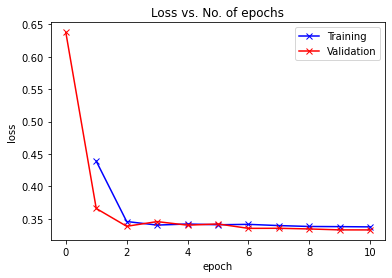

In [28]:
plot_losses(history)

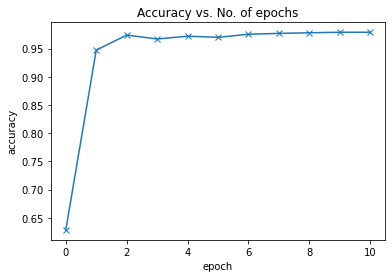

In [29]:
plot_accuracies(history)

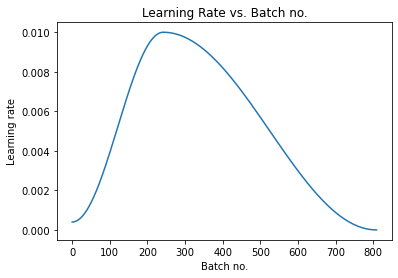

In [30]:
plot_lrs(history)